# ARIMAX Forecast trainer

In [85]:
#Create progress bar function
def progress_bar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = '\r')
    if iteration == total: 
        print()

In [86]:
# Importing the libraries
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.saving import save_model
import xgboost as xgb
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

days=1

# Importing the dataset
market_prices = pd.read_csv('/Users/jonathan/Desktop/Opportunistic_OM_WIND/Data/CLEAN_combined_data/2019_2023_final.csv')['price[EUR/MWh]'].values
dates = pd.read_csv('/Users/jonathan/Desktop/Opportunistic_OM_WIND/Data/CLEAN_combined_data/2019_2023_final.csv')['date'].values
# read the numpy file
wind_speed_forecasting = np.load('/Users/jonathan/Desktop/Opportunistic_OM_WIND/Data/CLEAN_combined_data/2021_2023_fake_forecast_from12oclock.npy')[:,:]
wind_speed = pd.read_csv('/Users/jonathan/Desktop/Opportunistic_OM_WIND/Data/CLEAN_combined_data/2019_2023_final.csv')['wind_speed'].values

In [87]:
# Create a DataFrame
data = []
for i in range(len(market_prices)-days*24):
    data.append([market_prices[i], dates[i], wind_speed[i+days*24]]) # append the price, date and wind speed (windspeed is shifted by days)

data = pd.DataFrame(data, columns=['price', 'date', 'wind_speed'])
# Convert 'date' to datetime, ensuring timezone info is retained if present
data['date'] = pd.to_datetime(data['date'], utc=True)

# If the data isn't timezone-aware, assume it's UTC and then convert. Otherwise, directly convert.
data['date'] = data['date'].dt.tz_convert('Europe/Copenhagen')  # Converting to Copenhagen timezone

data['day_of_week'] = data['date'].dt.dayofweek
data['hour'] = data['date'].dt.hour
data = pd.get_dummies(data, columns=['day_of_week'], prefix='weekday')

# Ensure all weekdays are represented
for i in range(7):
    if f'weekday_{i}' not in data.columns:
        data[f'weekday_{i}'] = 0

# Define peak hours and possibly other features
data['peak_hours'] = data['hour'].apply(lambda x: 1 if 8 <= x <= 20 else 0)

# Add lagged price features
for lag in range(1, 25):
    data[f'price_lag_{lag}'] = data['price'].shift(lag+24)

# Remove rows with NaN values introduced by lagging
data.dropna(inplace=True)


data_pre = data.copy()
data_pre = data_pre[data_pre['date']<pd.Timestamp('2021-12-31 23:59:00+0100', tz='Europe/Copenhagen')]
data_post = data.copy()
data_post = data_post[data_post['date']>=pd.Timestamp('2021-12-31 23:59:00+0100', tz='Europe/Copenhagen')]
data_pre.set_index('date', inplace=True)
data_post.set_index('date', inplace=True)
data_post_nontransform = data_post.copy()

# Organize columns
feature_columns = ['price', 'hour', 'peak_hours', 'wind_speed'] + [f'weekday_{i}' for i in range(7)] + [f'price_lag_{lag}' for lag in range(1, 25)]
data_pre = data_pre[feature_columns]
data_post = data_post[feature_columns]


In [88]:
# Remove the column using list comprehension
feature_columns = [col for col in feature_columns if col != 'price']

In [89]:
# Define the endogenous (target) and exogenous variables
train_endog = data_pre['price'].astype('float32')
train_exog = data_pre[feature_columns].astype('float32')

test_endog = data_post['price'].astype('float32')
test_exog = data_post[feature_columns].astype('float32')

# Normalize relevant columns
columns_to_normalize = ['hour', 'peak_hours', 'wind_speed'] + [f'price_lag_{lag}' for lag in range(1, 25)]

scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
train_exog[columns_to_normalize] = scaler.fit_transform(train_exog[columns_to_normalize])
test_exog[columns_to_normalize] = scaler.transform(test_exog[columns_to_normalize])

# Normalize the endogenous variable (price)
train_endog = pd.Series(scaler.fit_transform(np.array(train_endog).reshape(-1, 1)).flatten(), index=data_pre.index)
test_endog = pd.Series(scaler.transform(np.array(test_endog).reshape(-1, 1)).flatten(), index=data_post.index)
    

In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [93]:
# Define fit options
fit_options = {
    'disp': False,  # Suppress optimization output
    'maxiter': 2000  # Increase maximum number of iterations
}

# Optimization methods to try
methods = ['powell']

# Define a function to try different optimization methods
def fit_model_with_method(method, model, fit_options, start_params=None):
    try:
        return model.fit(method=method, options=fit_options, start_params=start_params)
    except Exception as e:
        print(f"Optimization with method {method} failed: {e}")
        return None

# Example with both constant and linear trend
model_const_linear_trend = SARIMAX(np.asarray(train_endog), order=(1, 1, 1), exog=np.asarray(train_exog), trend='ct')
results_const_linear_trend = None
for method in methods:
    results_const_linear_trend = fit_model_with_method(method, model_const_linear_trend, fit_options)
    print(f"Optimization with method {method} {'succeeded' if results_const_linear_trend.mle_retvals.get('converged') else 'failed'}")
    if results_const_linear_trend.mle_retvals.get('converged'):
        break

Optimization terminated successfully.
         Current function value: -0.165971
         Iterations: 3
         Function evaluations: 983
Optimization with method powell succeeded


In [94]:
# Forecast the next 96 hours (4 days)
i = 0
all_forecasts = []
for t in range(365):
    # Ensure the exogenous variables are correctly shaped for the prediction period
    exog_pred = np.asarray(test_exog)[24*t:24*(t+1)]
    # Make a 24-hour prediction
    prediction = results_const_linear_trend.get_forecast(steps=24, exog=exog_pred)

    if t==0:
        add = data_pre['price'].values[-1]
    else:
        add = data_post_nontransform['price'].values[24*t-1]
    # Extract the predicted mean
    predicted_mean = prediction.predicted_mean
    prediction = scaler.inverse_transform(np.array(predicted_mean).reshape(-1, 1)).flatten() + add
    all_forecasts = np.append(all_forecasts, prediction)

all_forecasts = all_forecasts.reshape(-1,days*24)

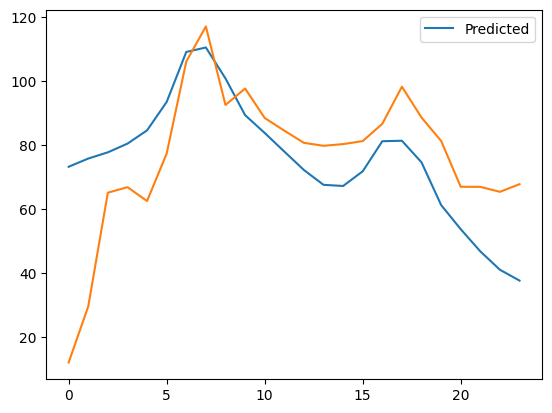

In [70]:
t = 300
plt.plot(all_forecasts[t,:], label='Predicted')
plt.plot(data_post_nontransform['price'].values[t*24:(t+1)*24])
plt.legend()

In [20]:
from sklearn.metrics import mean_squared_error

# Define a function to fit the model and return RMSE
def fit_and_evaluate_model(order, train_endog, train_exog, test_endog, test_exog, methods):
    model = SARIMAX(np.asarray(train_endog), order=order, exog=np.asarray(train_exog), trend='ct')
    results = None
    for method in methods:
        try:
            results = model.fit(method=method, options=fit_options)
            if results.mle_retvals.get('converged'):
                break
        except Exception as e:
            print(f"Optimization with method {method} failed: {e}")
            continue
    if results and results.mle_retvals.get('converged'):
        aic = results.aic
        return aic, results
    else:
        return np.inf, None

# Define the range for AR, I, and MA terms
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)

# Store the best model and its RMSE
best_aic = np.inf
best_order = None
best_results = None

# Loop over all combinations of p, d, q
for p in p_range:
    for d in d_range:
        for q in q_range:
            order = (p, d, q)
            print(f"Testing order: {order}")
            aic, results = fit_and_evaluate_model(order, train_endog, train_exog, test_endog, test_exog, methods)
            print(f"AIC for order {order}: {aic}")
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_results = results

print(f"\nBest order: {best_order} with AIC: {best_aic}")
if best_results:
    print(best_results.summary())

Testing order: (0, 0, 0)
Optimization terminated successfully.
         Current function value: 0.874671
         Iterations: 4
         Function evaluations: 1286
AIC for order (0, 0, 0): 46006.45428690373
Testing order: (0, 0, 1)
Optimization terminated successfully.
         Current function value: 0.401660
         Iterations: 18
         Function evaluations: 5681
AIC for order (0, 0, 1): 21168.759948567847
Testing order: (0, 0, 2)
Optimization terminated successfully.
         Current function value: 0.155524
         Iterations: 27
         Function evaluations: 8921
AIC for order (0, 0, 2): 8245.203364249839
Testing order: (0, 1, 0)
Optimization terminated successfully.
         Current function value: -0.154487
         Iterations: 1
         Function evaluations: 547
AIC for order (0, 1, 0): -8038.705714060374
Testing order: (0, 1, 1)
Optimization terminated successfully.
         Current function value: -0.165538
         Iterations: 3
         Function evaluations: 951
AIC 